## Rover Project Test Notebook
This notebook contains basic utility functions provided from the lesson, as well as utility and main processing functions that I developed.

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

## Quick Look at the Data
The dataset used for testing thoughout this notebook was created in the Simulator, by driving the robot throughout the "Gaming Area", while operating the Simulator in TRAINING MODE and RECORDING each frame of video and corresponding robot position data.

First, read in and display a random image from the my recorded data folder.

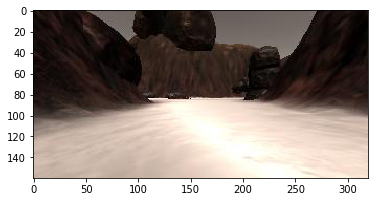

In [3]:
path = 'c:/Users/Stewartt/Documents/IMG/*'
img_list = glob.glob(path)
# Read a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  Use a grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

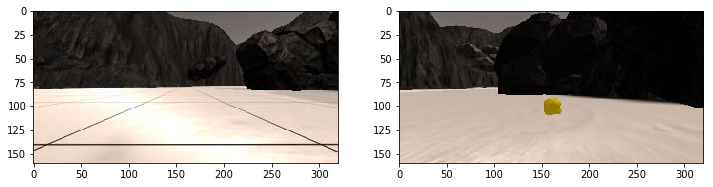

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

source, destination = [[ 14. 140.]
 [301. 140.]
 [200.  96.]
 [118.  96.]] [[155. 154.]
 [165. 154.]
 [165. 144.]
 [155. 144.]]


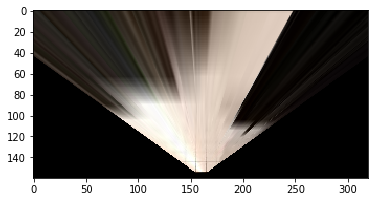

In [5]:
# Define a function to perform a perspective transform
# The example grid image from above is used for choosing source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
print ("source, destination =", source, destination)
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image to identify navigable terrain.

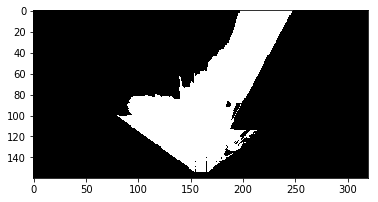

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(162, 162, 162)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    # *** Changed the value from 1 to 255, so I could convert the "gray scale" images back to BGR, and display them in video
    color_select[above_thresh] = 255
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations & Masking Utility Functions
Define the functions used to do coordinate transforms & image masking, and test them by applying them to an image.

Steering Command = 0.10529744484941621 degrees


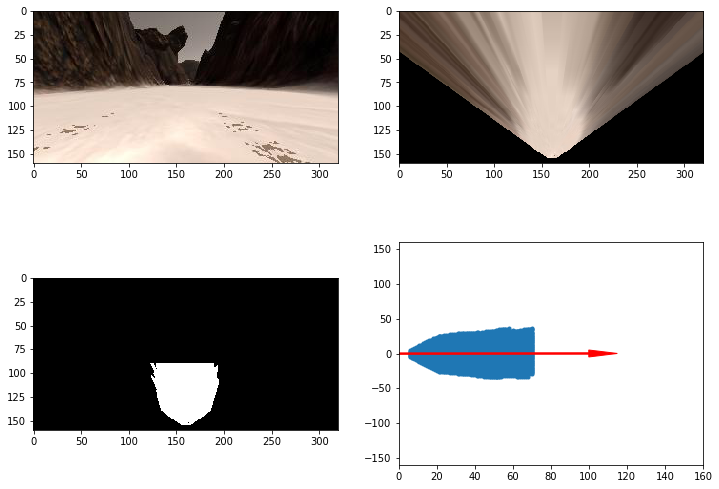

In [7]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Test these utility functions

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Define a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(140,imshape[0]),(120, 90), (200, 90), (imshape[1]-140,imshape[0])]], dtype=np.int32)
# Create an image with edges masked
masked_img = region_of_interest(threshed, vertices)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
#xpix, ypix = rover_coords(threshed)
xpix, ypix = rover_coords(masked_img)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Output plots showing results of the tests
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
#plt.imshow(threshed, cmap='gray')
# Rather than use a single-channel grayscale image, use a 3-channel RGB;
# need to be able to do this, to include the image in the RGB images that are built/output in process_image()
backtorgb = cv2.cvtColor(masked_img,cv2.COLOR_GRAY2BGR) 
plt.imshow(backtorgb)
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

# Test code for converting average of angles (mean direction) to degrees,
# and limiting the value to -15 to 15 degrees - use this code in drive_rover.py
avg_angle_degrees = mean_dir * 180/np.pi
steering = np.clip(avg_angle_degrees, -15, 15)
print ("Steering Command =", steering, "degrees")

# Define a function to identify rocks in an image

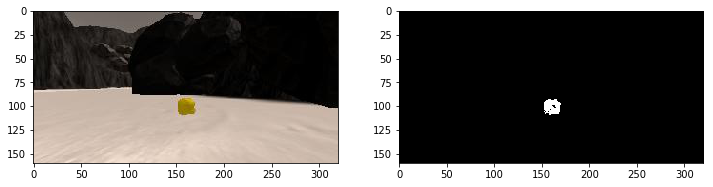

In [8]:
def find_rocks(img, levels=(110,110,50)):
    # Yellow rocks are bright in Red/Green channels, and dim in Blue channel
    rockpix = ((img[:,:,0] > levels[0]) & (img[:,:,1] > levels[1]) & (img[:,:,2] < levels[2]))
    color_select = np.zeros_like(img[:,:,0])
    color_select[rockpix] = 1
    return color_select

rock_map = find_rocks(rock_img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')

## Read in saved data and ground truth map of the world
The next cell reads saved data into a pandas dataframe.  Also read in is a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  Additionally, a class in created for storing telemetry data and pathnames to images.  When this class is instantiated (data = Databucket()) the global variable data is used to access telemetry and map data within the process_image() function in the following cell.  

In [9]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
df = pd.read_csv('c:/Users/Stewartt/Documents/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that is refered to in the process_image() function below
data = Databucket()

## Process stored images

process_image() performs image analysis and mapping.  In code cell 13 below, process_image() is used in conjunction with the moviepy video processing package to create a video from these processed images. The input images are created and saved while RECORDING in the simulator, while the simulator is operating in TRAINING MODE.  These individual images are passed into process_image(), and an output_image is built up here, and each output image is stored as one frame of video.  

In [15]:
# Define function to process stored input images, and corresponding rover X/Y positions and yaw angles.
# This function will be used by moviepy to create an output video.
def process_image(img):
    """
    PSUEDO CODE for process_image():
      1) Apply perspective transform to generate "warped birds-eye view" from original input image
      2) Apply color threshold to identify navigable terrain/obstacles/rock samples
      3) Apply a mask to thresholded image, to eliminate sky, and other extreme extraneous detections
      4) Convert thresholded image pixel values to rover-centric coords
      5) Convert rover-centric pixel values to world coords
      6) Update worldmap (to be displayed in lower-left quadrant)
      7) Construct a mosaic image consisting of original, warped, thresholded, & map images
      8) Place text labels overlayed on top of each of the Quadrants in the image
      9) Return the mosaic/labeled image
    NOTES:
      - The "source" and "destination" point variables, used for perspective transform,
        are defined in Code Cell 5 above
      - The "data" object of Class Databucket(), containing general global processing data,
        is defined in Code Cell 8 above
    """
    # 1) Apply perspective transform to generate "warped birds-eye view", from original input image
    warped = perspect_transform(img, source, destination)
    
    # 2) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)     #    Create warped/thresholded image
    obs_map = np.absolute(np.float32(threshed)-1)
    rock_map = find_rocks(warped)
    
    # 3) Apply a mask to thresholded image, to eliminate sky, and other extreme extraneous detections
    imshape = img.shape
    # Define a four sided polygon to mask
    vertices = np.array([[(148,imshape[0]),(124, 96), (196, 96), (imshape[1]-148,imshape[0])]], dtype=np.int32)    
    masked_img = region_of_interest(threshed, vertices) # Create an image with top and side edges masked
    obs_masked_img = region_of_interest(obs_map, vertices) # Again for obstacle map
    rock_masked_img = region_of_interest(rock_map, vertices) # Again for rock image
    
    # 4) Convert thresholded/masked image pixel values to rover-centric coords
    xpix, ypix = rover_coords(masked_img) # Extract navigable terrain pixels
    obs_xpix, obs_ypix = rover_coords(obs_masked_img) # Extract navigable terrain pixels
    if rock_masked_img.any(): # Extract rock pixels
        rock_xpix, rock_ypix = rover_coords(rock_masked_img)
        
    # 5) Convert rover-centric pixel values to world coords
    rover_xpos = data.xpos[data.count]  # Get Rover X,Y,Yaw position from data bucket
    rover_ypos = data.ypos[data.count]
    rover_yaw = data.yaw[data.count]     
    scale = 10
    # Get navigable pixel positions in world coords
    x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, rover_ypos, rover_yaw, data.worldmap.shape[0], scale)
    # Get obstacle pixel positions in world coords
    obs_x_world, obs_y_world = pix_to_world(obs_xpix, obs_ypix, rover_xpos, rover_ypos, rover_yaw, data.worldmap.shape[0], scale)
    # Get rock pixel positions in world coords
    if rock_masked_img.any():
        rock_x_world, rock_y_world = \
            pix_to_world(rock_xpix, rock_ypix, rover_xpos, rover_ypos, rover_yaw, data.worldmap.shape[0], scale)
    
    # 6) Update worldmap (to be displayed in lower-left quadrant)
    data.worldmap[y_world, x_world, 2] = 255     # Add pixel positions to worldmap
    data.worldmap[obs_y_world, obs_x_world, 0] = 255     # Add pixel positions to worldmap
    nav_pix = data.worldmap[:,:,2] > 0
    data.worldmap[nav_pix,0] = 0
    if rock_masked_img.any(): # Add rock pixel positions to worldmap
        data.worldmap[rock_y_world, rock_x_world,:] = 255  # Add rock pixel positions (as white) to worldmap

    # 7) Construct and return a mosaic image consisting of original, warped, thresholded, & map images 
    # Create blank mosaic image, sized to hold 4 "quadrants" of images
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3)) 
    output_image[0:img.shape[0], 0:img.shape[1]] = img    # Original image is placed in the upper left quadrant
    output_image[0:img.shape[0], img.shape[1]:] = warped  # Add the warped image in the upper right hand quadrant
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0) # Overlay worldmap with ground truth map
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add) # Flip map overlay so y-axis points upward and output in lower left quadrant
    backtorgb = cv2.cvtColor(masked_img,cv2.COLOR_GRAY2RGB)
    output_image[img.shape[0]:img.shape[0]+160, img.shape[1]:] = backtorgb # Add warped/thresholded image in lower right quadrant
    
    # 8) Place text labels overlayed on top of each of the Quadrants in the image
    cv2.putText(output_image,"Original Frames", (20, 20), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(output_image,"Birds-Eye \"Warped\" Frames", (img.shape[1]+20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(output_image,"Warped/Thresholded/Masked Frames", (img.shape[1]+20, img.shape[0]+20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(output_image,"Map - Legend:", (5, img.shape[0]+8), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255), 1)
    # Output Legend Descriptions for the colors used on the Map
    cv2.putText(output_image,"Green=UnderlyingGroundTruth(Provided)", (5, img.shape[0]+20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255), 1)
    cv2.putText(output_image,"Red=Obstacles", (5, img.shape[0]+32), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255), 1)
    cv2.putText(output_image,"Blue=Navigable", (5, img.shape[0]+44), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255), 1)
    cv2.putText(output_image,"White=Rocks", (5, img.shape[0]+56), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255), 1)
    
    # Keep track of the index in the Databucket()
    if data.count < len(data.images) - 1:
        data.count += 1 

    # 9) Return the mosaic/labeled image
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|█████████████████████████████████████████████████████████████████████████████| 3687/3687 [00:24<00:00, 149.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

Wall time: 24.8 s


### This following code cell functions as an inline video player
Select PLAY (>) in the application appearing in the output cell, to playback the video.
The project's mp4 video file, that has been saved in /output folder, can also be viewed independently by using an external video player.

In [17]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))